# Marketing Analytics - RFM Modeling

  When it comes to marketing, if you're trying to talk to everybody, you’re going to have a difficult time reaching anybody. Vague and generic messages are far less likely to resonate with audiences than specific, direct communication – which is why targeting in marketing is so important.
Smart marketers understand the importance of "know thy customer". Instead of simply focusing on generating more clicks, marketers must follow the paradigm shift from increased CTRs (Click-Through Rates) to retention, loyalty, and building customer relationships.

Instead of analyzing the entire customer base as a whole, it's better to segment them into homogeneous groups, understand the traits/behaviour of each group, and engage them with relevant targeted campaigns. 

One of the most popular, easy-to-use, and effective segmentation methods which enable marketers to analyze the customer behavior is RFM analysis.

## Table of Contents:

**1. Introduction**

**2. Data Preprocessing**

**3. Exploratory Analysis**

**4. RFM Modeling** 
    
**5. Conclusion**

## 1. Introduction   

RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

Businesses that lack the monetary aspect, like viewership, readership, or surfing-oriented products, could use Engagement parameters instead of Monetary ones. This results in using **RFE** (Recency, Frequency, Engagement) – a variation of RFM. Further, this Engagement parameter could be defined as a composite value based on metrics such as bounce rate, visit duration, number of pages visited, time spent per page, etc.

RFM features of customers illustrates these characteristics:
* The more recent they purchase, the more responsive they are to the promotions.
* The more frequent they purchase, the more engaged and satisfied they are.
* The more monetary value helps to differentiate high spenders vs low spenders.

In this article, we are going to work with the online-retail dataset from UCI Machine Learning repository.

**Dataset Information:**

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**Attribute Information:**

* *InvoiceNo*: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

* *StockCode*: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

* *Description*: Product (item) name. Nominal.

* *Quantity*: The quantities of each product (item) per transaction. Numeric.

* *InvoiceDate*: Invoice Date and time. Numeric, the day and time when each transaction was generated.

* *UnitPrice*: Unit price. Numeric, Product price per unit in sterling.

* *CustomerID*: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

* *Country*: Country name. Nominal, the name of the country where each customer resides.

In this article, I will guide you through the complete process of RFM modeling and analysis to segment customers based on their transactional behaviour.

## 2. Data Preprocessing

The Primary step in any modeling/analysis is the data preprocessing.

To do the analysis, we need the data. I have already downloaded the data from the UCI Machine Learning repository and saved in my local direcotry. Here is the link for the dataset https://archive.ics.uci.edu/ml/datasets/online+retail#.

First import all the necessary libraries and load the data.

In [99]:
# Data Manipulation libraries
import pandas as pd
import numpy as np
import missingno as msno

from datetime import timedelta

# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Loading the data
data = pd.read_csv("OnlineRetail.csv", encoding="unicode_escape", parse_dates=['InvoiceDate'])
print("Total number of transactions happened in the given period: "+ str(data.shape[0]))
data.head(5)

Total number of transactions happened in the given period: 541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Checking the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# Checking for missing Values
pd.DataFrame(zip(data.isnull().sum(), data.isnull().sum()/len(data)), columns=['count', 'proportion'], index=data.columns)

,count,proportion
InvoiceNo,0,0.000000
StockCode,0,0.000000
Description,1454,0.002683
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
CustomerID,135080,0.249267
Country,0,0.000000


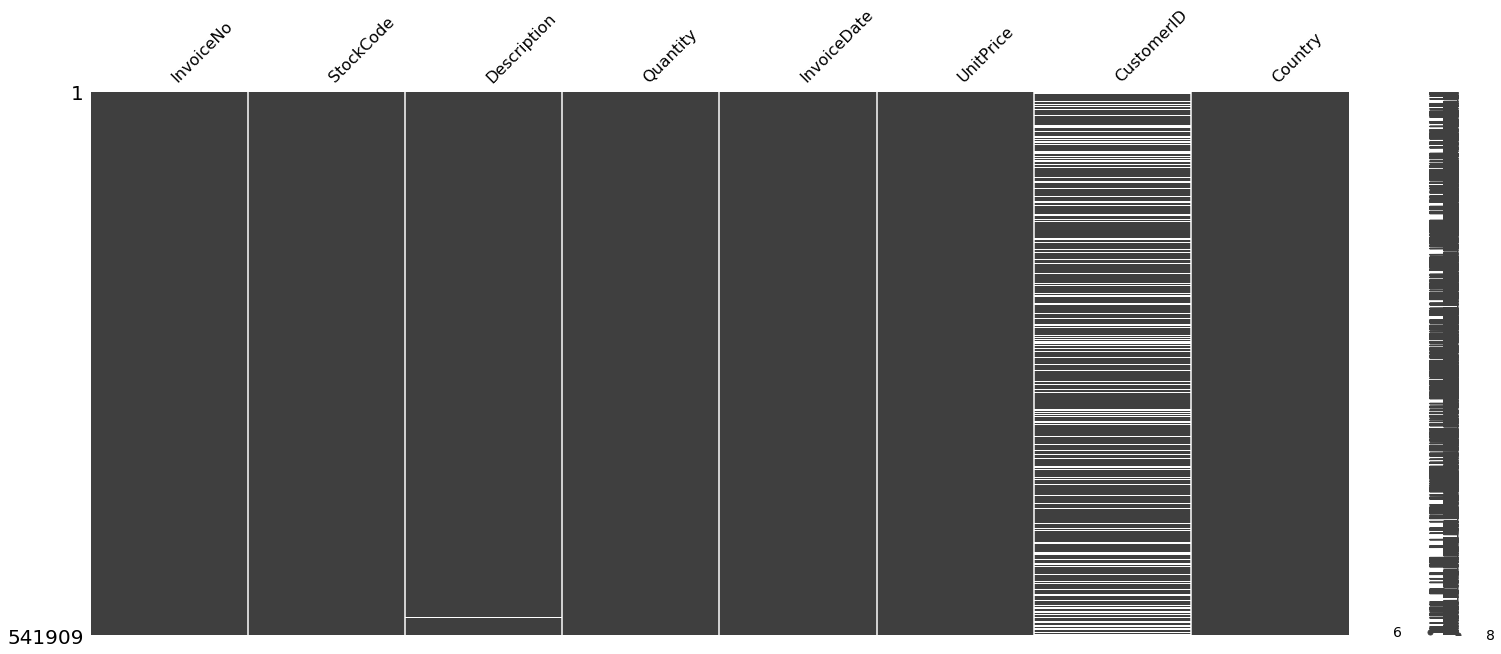

In [5]:
# Visualizing the missing values
msno.matrix(data)

There seems to be missing values in the Description and CustomerID column. 

Since our analysis objective is to identify customer groups, the column CustomerID is should contain unique identifiers for customers. Hence, we can drop the NA values since the data without CustomerID is not much helpful for our task.


In [6]:
# Removing null CustomerIDs
main = data.copy()
data = data[pd.notnull(data['CustomerID'])]

In [7]:
# Descriptive Statistics
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


From the descriptive statistics, we can see that the Quantity has negative values. This could mean that either the product is returned/refunded.

Lets explore further on this

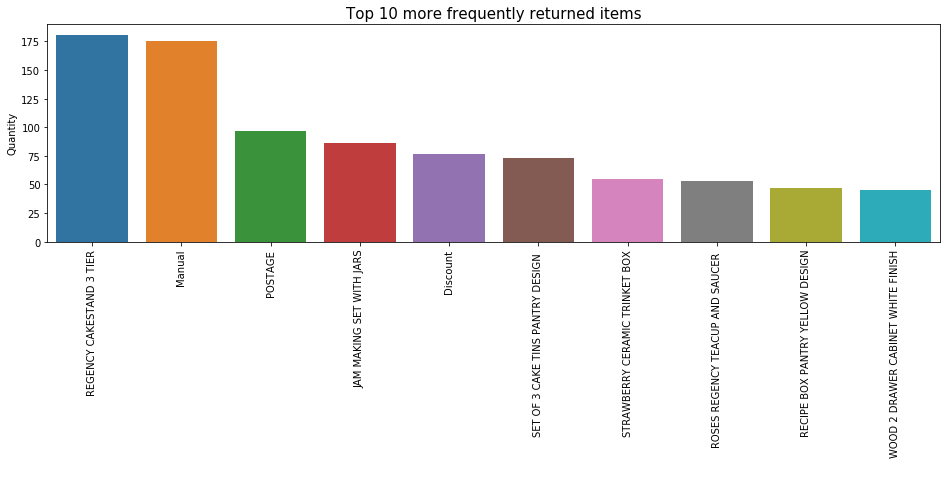

In [8]:
# Filter for most frequently returned items
refunds = data[data['Quantity']<0]
refunds = refunds.groupby('Description')['Quantity'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(16,4))
sns.barplot(x= refunds['Description'], y=refunds['Quantity'])
plt.title("Top 10 more frequently returned items", size=15)
plt.xticks(rotation=90)
plt.xlabel(" ")
plt.show()

These are some of the most frequently returned items on the site. 

From the descriptive statistics, the maximum Quantity bought is 80.9K, but if you check carefully 75% of Quantity values are less than or equal to 10. The large values in Quantity is possible here because the ecommerce platform is for wholesalers.

The maximum value of UnitPrice is 13.5K but 75% of prices are below 5. Lets explore further the reason for this high values.

In [9]:
data[data['UnitPrice']>1000].tail(7)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536.0,France
467436,576339,DOT,DOTCOM POSTAGE,1,2011-11-14 15:27:00,1500.36,14096.0,United Kingdom
467437,C576338,CRUK,CRUK Commission,-1,2011-11-14 15:27:00,1038.75,14096.0,United Kingdom
494728,578270,DOT,DOTCOM POSTAGE,1,2011-11-23 13:39:00,1270.06,14096.0,United Kingdom
508459,579196,DOT,DOTCOM POSTAGE,1,2011-11-28 15:54:00,1526.76,14096.0,United Kingdom
528082,580727,DOT,DOTCOM POSTAGE,1,2011-12-05 17:17:00,1599.26,14096.0,United Kingdom
528087,C580726,CRUK,CRUK Commission,-1,2011-12-05 17:17:00,1100.44,14096.0,United Kingdom


There are some odd descriptions like Manual, POSTAGE, DOTCOM POSTAGE, CRUK Commission, and Discount. Let us check what does these mean:
* POSTAGE/DOTCOM POSTAGE: The amount spent by the user on postages.
* CRUK Commission: An initiative to pay some part of the sales to the Cancer Research UK (CRUK).
* Manual: Since there is no proper definition we can think of this as manual service provided for the purchase of an item.
* Discount: This explains the discount provided for a product.

Except for Discount, all the other categories do not directly affect the sales. Hence, we can remove those from the data.

In [10]:
data = data[~data['Description'].isin(['POSTAGE', 'DOTCOM POSTAGE', 'CRUK Commission', 'Manual'])]
data.describe()

,Quantity,UnitPrice,CustomerID
count,405136.000000,405136.000000,405136.000000
mean,12.096437,2.930269,15294.854688
std,249.170911,5.507490,1710.142754
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,5.000000,1.950000,15159.000000
75%,12.000000,3.750000,16794.000000
max,80995.000000,1867.860000,18287.000000


Lets calculate the total sales value for each transaction from the quantity and unit price.

In [11]:
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [12]:
# Printing the details of the dataset
maxdate = data['InvoiceDate'].dt.date.max()
mindate = data['InvoiceDate'].dt.date.min()
unique_cust = data['CustomerID'].nunique()
unique_stocks = data['StockCode'].nunique()
tot_quantity = data['Quantity'].sum()
tot_sales = data['TotalSales'].sum()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total number of unique stocks: {unique_stocks}")
print(f"Total Quantity Sold: {tot_quantity}")
print(f"Total Sales for the period: {tot_sales}")

The Time range of transactions is: 2010-12-01 to 2011-12-09
Total number of unique customers: 4363
Total number of unique stocks: 3680
Total Quantity Sold: 4900702
Total Sales for the period: 8287768.103999999


## 3. Exploratory Analysis

Before jumping into the Modeling, it is always important and necessary to explore the data. This helps us to understand the data and the business better. 

Exploratory data analysis helps us to answer questions such as:
* What are the most purchased products in the platform?
* People from which country are transacting more?
* Which hour of the day, day of the week is when the most transactions happen?
* What is the trend of transactions for the given period?

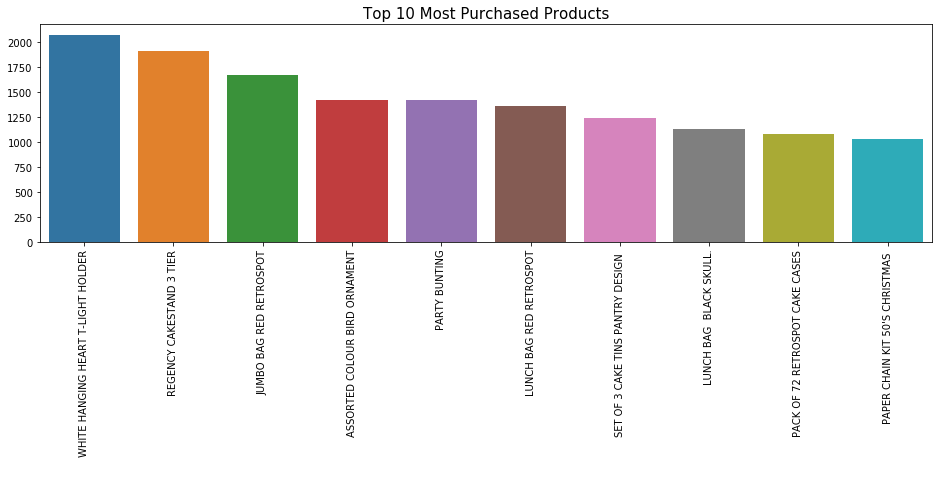

In [13]:
# The most purchased products from the website
top_purchase = data.groupby('Description')['TotalSales'].count().sort_values(ascending=False)[:10]

plt.figure(figsize=(16,4))
sns.barplot(x=top_purchase.index, y=top_purchase.values)
plt.xticks(rotation=90)
plt.title("Top 10 Most Purchased Products", size=15)
plt.xlabel(" ")
plt.show()

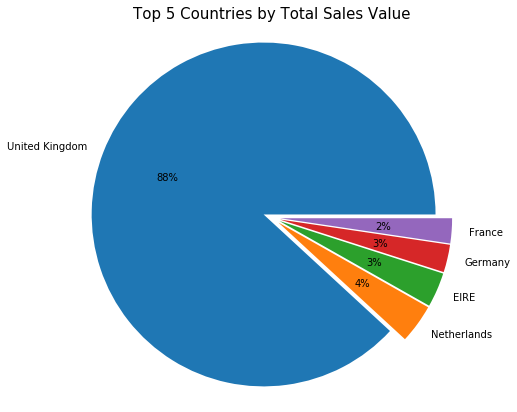

In [72]:
# Top countries by sales value
top_country = data.groupby('Country')['TotalSales'].sum().sort_values(ascending=False)[:10]labels = top_country[:5].index
size = top_country[:5].values

plt.figure(figsize=(7,7))
plt.pie(size, labels=labels, explode=[0.05]*5, autopct='%1.0f%%')
plt.title("Top 5 Countries by Total Sales Value", size=15)
plt.axis('equal')
plt.show()

Now we will explore on how transaction trend is changing within a day, week and across months.

To analyze this, we need to create new features from the InvoiceDate column - which denotes the date and time each transaction takes place.

In [15]:
data['Hour'] = data['InvoiceDate'].dt.hour
data['Weekday'] = data['InvoiceDate'].dt.weekday
data['WeekdayName'] = data['InvoiceDate'].dt.weekday_name
data['Month'] = data['InvoiceDate'].dt.month
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Hour,Weekday,WeekdayName,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,8,2,Wednesday,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,2,Wednesday,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,8,2,Wednesday,12


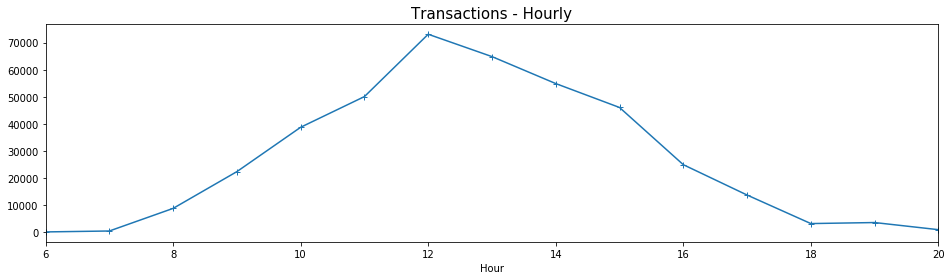

In [16]:
# Transaction trend in hour of the day
hour = data.groupby('Hour')['Quantity'].count()
plt.figure(figsize=(16,4))
hour.plot(marker='+')
plt.title("Transactions - Hourly", size=15)
plt.show()

The transaction on the website starts to increase around 7 in the morning and peaks at 12PM in the noon. Then the trend slowly decreases and ends at 6PM in the evening. 

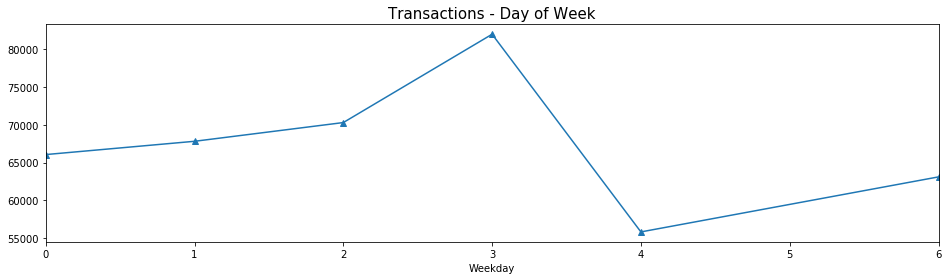

In [17]:
# Transaction trend in day of week
weekday = data.groupby('Weekday')['Quantity'].count()
plt.figure(figsize=(16,4))
weekday.plot(marker='^')
plt.title("Transactions - Day of Week", size=15)
plt.show()

People tend to purchase more from Monday to Thursday. Surprisingly, there are no transactions that took place on Saturdays for the given time period in the data.

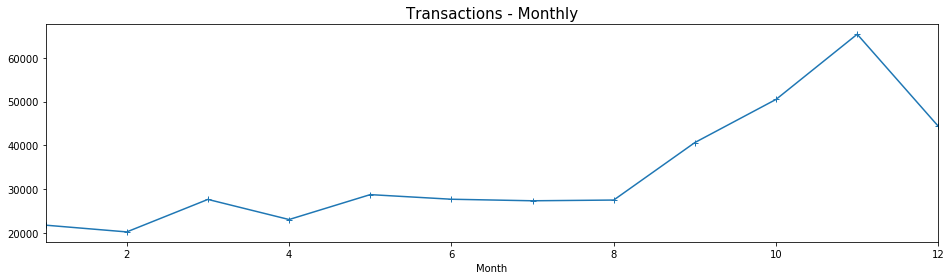

In [18]:
# Transaction trend across months
month = data.groupby('Month')['Quantity'].count()
plt.figure(figsize=(16,4))
month.plot(marker='+')
plt.title("Transactions - Monthly", size=15)
plt.show()

Monthly trend reveals that the number of people using the platform is showing an increasing trend. Further, the rate of increase stayed flat till August 2011 and rapidly increasing from September 2011. 

The sudden dip in the month of December is because we have only data till December 9th.

## 4. RFM Modeling

To do the RFM analysis, we need to create 3 features from the data:
* **Recency**   - Latest date - Last invoice date. (Number of days since the last purchase date)
* **Frequency** - count of invoice numbers. (Total number of transactions made by a unique customer)
* **Monetary**  - Sum of Total sales. (Total value of transacted sales by each customer)

Now, let's create a function which can be used to generate the RFM features.

In [96]:
def RFM_Features(df, customerID, invoiceDate, transID, sales):
    ''' Create the Recency, Frequency, and Monetary features from the data '''
    # Final date in the data + 1 to create latest date
    latest_date = df[invoiceDate].max() + timedelta(1)
    
    # RFM feature creation
    RFMScores = df.groupby(customerID).agg({invoiceDate: lambda x: (latest_date - x.max()).days, 
                                          transID: lambda x: len(x), 
                                          sales: lambda x: sum(x)})
    
    # Converting invoiceDate to int since this contains number of days
    RFMScores[invoiceDate] = RFMScores[invoiceDate].astype(int)
    
    # Renaming column names to Recency, Frequency and Monetary
    RFMScores.rename(columns={invoiceDate: 'Recency', 
                         transID: 'Frequency', 
                         sales: 'Monetary'}, inplace=True)
    
    return RFMScores.reset_index()

In [206]:
RFM = RFM_Features(df=data, customerID= "CustomerID", invoiceDate = "InvoiceDate", transID= "InvoiceNo", sales="TotalSales")
RFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,182,4310.00
2,12348.0,75,27,1437.24
3,12349.0,19,72,1457.55
4,12350.0,310,16,294.40


The above function can be used to create RFM features for any dataset by specifying the actual names of the respective columns from the dataset you are working on.

Let's explore some descriptive statistics of the new features.

,CustomerID,Recency,Frequency,Monetary
count,4363.000000,4363.000000,4363.000000,4363.000000
mean,15299.772863,92.096264,92.857208,1899.557209
std,1721.852042,100.912621,232.116234,8276.968189
min,12346.000000,1.000000,1.000000,-1192.200000
25%,13813.500000,17.000000,17.000000,294.295000
50%,15299.000000,50.000000,42.000000,645.650000
75%,16777.500000,143.000000,101.000000,1592.120000
max,18287.000000,374.000000,7971.000000,278571.620000


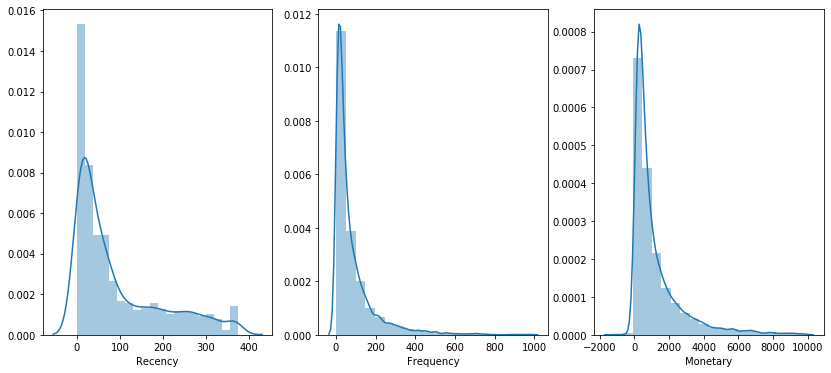

In [207]:
# Descriptive Stats
display(RFM.describe())

# Distributions of Recency, Frequency, and Monetary features
# Here we will filter out the extreme values in the Frequency and Monetary columns to avoid the skewness the distribution
fig, ax = plt.subplots(1,3, figsize=(14,6))

sns.distplot(RFM.Recency, bins=20, ax=ax[0])
sns.distplot(RFM[RFM['Frequency']<1000]['Frequency'], bins=20, ax=ax[1])
sns.distplot(RFM[RFM['Monetary']<10000]['Monetary'], bins=20, ax=ax[2])
plt.show()

To conduct RFM analysis, we need to rank the customers based on each RFM attribute separately.

Assume that we rank these customers from 1-4 using RFM values. (1-low score & 4-High score)

**Steps to be followed for RFM ranking:**
1. Sort the Recency column by **most recent purchases at the top.** For Frequency and Monetary features sort it by the **most frequent** and **most valuable** purchases at the top.
2. If you are using N-scale ranking to rank the customers then you have to divide the sorted values of the features into 1/N groups. Here, we are using 4-scale ranking hence we need to divide the values into 4 groups.

we can do both the sorting and grouping using pandas **df.quantile** method by providing the number of quantiles as a list.





**NOTE:** The value of N decides the number of different RFM rank groups you want to create. All possible combination of ranks from 1-N for all the three RFM features results in N^3 rank groups ranging from 111(lowest) to NNN(highest).

In our case N=4, hence we could have a maximum of 4^3 = 64 rank groups with scores from 111 to 444.

In [208]:
# Creating quantiles 
Quantiles = RFM[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])
Quantiles = Quantiles.to_dict()
Quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 143.0},
 'Frequency': {0.25: 17.0, 0.5: 42.0, 0.75: 101.0},
 'Monetary': {0.25: 294.29499999999996,
  0.5: 645.6500000000001,
  0.75: 1592.1200000000003}}

In [209]:
# Creating RFM ranks
def RFMRanking(x, variable, quantile_dict):
    ''' Ranking the Recency, Frequency, and Monetary features based on quantile values '''
    
    # checking if the feature to rank is Recency
    if variable == 'Recency':
        if x <= quantile_dict[variable][0.25]:
            return 4
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 3
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 2
        else:
            return 1
    
    # checking if the feature to rank is Frequency and Monetary
    if variable in ('Frequency','Monetary'):
        if x <= quantile_dict[variable][0.25]:
            return 1
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 2
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 3
        else:
            return 4

In [210]:
RFM['R'] = RFM['Recency'].apply(lambda x: RFMRanking(x, variable='Recency', quantile_dict=Quantiles))
RFM['F'] = RFM['Frequency'].apply(lambda x: RFMRanking(x, variable='Frequency', quantile_dict=Quantiles))
RFM['M'] = RFM['Monetary'].apply(lambda x: RFMRanking(x, variable='Monetary', quantile_dict=Quantiles))

In [211]:
RFM.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12346.0,326,2,0.00,1,1,1
1,12347.0,2,182,4310.00,4,4,4
2,12348.0,75,27,1437.24,2,2,3
3,12349.0,19,72,1457.55,3,3,3
4,12350.0,310,16,294.40,1,1,2


We have calculated the ranks for each individual attribute of RFM at the customer level. We can use this to find the total number of rank groups that are created based on our ranking scale. 

To do this you can simply combine all the individual R, F, and M ranks to check how many groups are created and the share of customers in each segment.

For our case, the maximum number of groups should be 4^3 = 64. Lets, check if it is true.

In [188]:
RFM['Group'] = RFM['R'].apply(str) + RFM['F'].apply(str) + RFM['M'].apply(str)
RFM.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group
0,12346.0,326,2,0.00,1,1,1,111
1,12347.0,2,182,4310.00,4,4,4,444
2,12348.0,75,27,1437.24,2,2,3,223
3,12349.0,19,72,1457.55,3,3,3,333
4,12350.0,310,16,294.40,1,1,2,112


In [180]:
# Check the number of score segments
RFM.Group.value_counts()

444    469
111    392
344    209
122    208
211    180
      ... 
124      6
142      4
414      3
441      1
241      1
Name: Group, Length: 62, dtype: int64

Note that the total rank groups created is 62 and this makes sense because the maximum number of groups based on our ranking scale is 64.

The reason for getting 62 instead of 64 rank groups is because there might be some missing combinations in the ranks of R, F, and M.

Finally, we can create a composite score for these customers by combining their individual R, F, and M ranks to arrive at an aggregated RFM score. This RFM score, displayed in the table below, is simply the average of the individual R, F, and M ranks, obtained by giving equal weights to each RFM attribute.

In [190]:
RFM["Score"] = RFM[['R', 'F', 'M']].sum(axis=1)
RFM.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score
0,12346.0,326,2,0.00,1,1,1,111,3
1,12347.0,2,182,4310.00,4,4,4,444,12
2,12348.0,75,27,1437.24,2,2,3,223,7
3,12349.0,19,72,1457.55,3,3,3,333,9
4,12350.0,310,16,294.40,1,1,2,112,4


We can now use this score to assign Loyalty level to each customer instead of handling the N^3 rank groups. The Loyalty level will capture different behaviours of the customers and also helps in analyzing and targeting each customer group based on their behaviour.

In [195]:
# Loyalty levels
loyalty = ['Bronze', 'Silver', 'Gold', 'Platinum']
RFM['Loyalty_Level'] = pd.qcut(RFM['Score'], q=4, labels= loyalty)
RFM.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score,Loyalty_Level
0,12346.0,326,2,0.00,1,1,1,111,3,Bronze
1,12347.0,2,182,4310.00,4,4,4,444,12,Platinum
2,12348.0,75,27,1437.24,2,2,3,223,7,Silver
3,12349.0,19,72,1457.55,3,3,3,333,9,Gold
4,12350.0,310,16,294.40,1,1,2,112,4,Bronze


In [199]:
behaviour = RFM.groupby('Loyalty_Level')[['Recency', 'Frequency', 'Monetary', 'Score']].mean()
behaviour

,Recency,Frequency,Monetary,Score
Loyalty_Level,,,,
Bronze,193.224537,14.944444,245.596529,4.094907
Silver,86.968478,33.919565,643.832990,6.488043
Gold,46.435249,83.040613,1395.621703,8.982375
Platinum,12.812352,292.391924,6598.411318,11.557007


We have successfully grouped 62 segments based on individual R, F, M scores into 4 broad loyalty levels. Let's explore the characteristics of each loyalty levels.

**Customer Behaviour and potential targeting techniques for each Loyalty Level:**
1. **Platinum:** People in this group are more frequent buyers with average days since the last purchase is 13 and average number of times they have transacted in the platform is about 292 times in the last 1 year. Also, their average sales value is 6.5K pounds.
These are your most loyal customers, who bought recently, most often, and are heavy spenders. Reward these customers so that they can become an early adopters for your future products and help to promote your brand.

2. **Gold:** This group has an average frequency of 83 times and recency of 46 days. This group is also high spenders with average sales of about 1.3K pounds. 
 These are your recent customers with an average frequency and who spent a good amount. Offer membership or loyalty programs or recommend related products to upsell them and help them become your Platinum members.

3. **Silver:** People in this group have made a transaction on the platform about 87 days ago. Their frequency and monetary values are 34 times and 644 pounds respectively.
These are your customers who purchased a decent number of times and spent good amounts, but haven’t purchased recently. Sending them personalized campaigns, offers, and product recommendations will help to reconnect with them.

4. **Bronze:** This is the dormant group with average days since their last purchase is 193. They have transacted around 15 times in the platform with average sales of 245 pounds. 
These are customers who used to visit and purchase in your platform, but haven’t been visiting recently. Bring them back with relevant promotions, and run surveys to find out what went wrong and avoid losing them to a competitor.

## 5. Conclusion

RFM is a data-driven customer segmentation technique that allows marketers to make informed decisions. It empowers marketers to quickly identify and segment users into homogeneous groups and target them with differentiated and personalized marketing strategies. This in turn improves user engagement and retention.

I have used equal weightage scheme for each RFM variables in this analysis. But depending on the nature of your businesses, you can increase or decrease the relative importance of each RFM variable to arrive at the final score. For example:

* In a *consumer durables* business, the monetary value per transaction is normally high but frequency and recency is low. For example, you can’t expect a customer to purchase a refrigerator or air conditioner on a monthly basis. In this case, a marketer could give more weight to monetary and recency aspects rather than the frequency aspect.

* In a *retail* business, customers purchase products every month or every week, so they will have a higher recency and frequency score than monetary score. Accordingly, the RFM score could be calculated by giving more weight to R and F scores than M.

* For *streaming* business like Hotstar or Netflix, a binge watcher will have a longer session length than a mainstream consumer watching at regular intervals. For bingers, engagement and frequency could be given more importance than recency, and for mainstreamers, recency and frequency can be given higher weights than engagement to arrive at the RFE score.

Thanks for reading this far. I hope this article helps you to understand the concept and process behind creating the RFM Model. You can follow these steps to create your own RFM model to segment customers.

Happy Learning!!